# Self Guided DIP Implementation for Shepp-Logan Phantom Data (Study I):

### Import libraries and utilities:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import torch
import torch.optim as optim
import torch.fft as fft
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
# from tqdm.notebook import tqdm
import sigpy as sp

from skimage.metrics import peak_signal_noise_ratio as compute_psnr
from skimage.metrics import structural_similarity as compute_ssim
import pickle
import glob

from models import UNet, FullUNet, MediumUNet, OneLayerUNet, ExtraDeepUNet, SuperDeepUNet
from utils.common_utils import *
from utils.fftc import * 

import os# os.environ['CUDA_VISIBLE_DEVICES'] = '1'
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

/home/ahmad.sultan/.conda/envs/DISCUS-Sultan/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Check available hardware:

In [2]:
# check available hardware:
def list_cuda_devices():
    if torch.cuda.is_available():
        num_devices = torch.cuda.device_count()
        print(f"Number of available CUDA devices: {num_devices}")
        for i in range(num_devices):
            print(f"Device {i}: {torch.cuda.get_device_name(i)}")
            print(f"  Memory Allocated: {torch.cuda.memory_allocated(i) / 1024 ** 2:.2f} MB")
            print(f"  Memory Cached: {torch.cuda.memory_reserved(i) / 1024 ** 2:.2f} MB")
            print(f"  Total Memory: {torch.cuda.get_device_properties(i).total_memory / 1024 ** 2:.2f} MB")
    else:
        print("CUDA is not available.")

list_cuda_devices()

Number of available CUDA devices: 2
Device 0: NVIDIA GeForce RTX 4090
  Memory Allocated: 0.00 MB
  Memory Cached: 0.00 MB
  Total Memory: 24217.31 MB
Device 1: NVIDIA GeForce RTX 4090
  Memory Allocated: 0.00 MB
  Memory Cached: 0.00 MB
  Total Memory: 24217.31 MB


### Define additional utilities:

In [3]:
# excluding MPS for single coil data
def fft_with_shifts(img):
    return fft.fftshift(fft.fft2(fft.ifftshift(img), norm='ortho'))

def ifft_with_shifts(ksp):
    return fft.fftshift(fft.ifft2(fft.ifftshift(ksp), norm='ortho'))

def ksp_and_mps_to_gt(ksp): # multi-coil kspace and sensitivity maps to ground truth image
    gt = ifft_with_shifts(ksp)
    # gt = torch.sum(gt, axis=0) # axis=0 is the coil dim.
    return gt

def mps_and_gt_to_ksp(gt): # maps and ground truth image to multi-coil kspace
    ksp = fft_with_shifts(gt)
    return ksp


def np_to_torch(img_np):
    '''Converts image in numpy.array to torch.Tensor.

    From C x W x H [0..1] to  C x W x H [0..1]
    '''
    return torch.from_numpy(img_np)[None, :]

def torch_to_np(img_var):
    '''Converts an image in torch.Tensor format to np.array.

    From 1 x C x W x H [0..1] to  C x W x H [0..1]
    '''
    return img_var.detach().cpu().numpy()[0]

# NMSE and SSIM functions:
def compute_nmse(x, xHat): # for a batch of images: assuming 1st dimension to be Batch dimension
    nmse = 10*torch.log10(torch.mean(torch.sum((x-xHat)**2, dim=(-1,-2)) / torch.sum(x**2, dim=(-1,-2))))
    return nmse


### Select study parameters and dataset: 

In [4]:
# choose parametrs:
N=64
R=2

# select series: a lsit of simulated series: {"rotation", "translation", "both"}
series = 'both' 
data_load = '../data/SL-ph/' + series + "/"

## Load simulated data

In [5]:

yN = np.load(data_load + 'y_N_%d_R_%d'%(N,R) +'.npy')
ynN = np.load(data_load + 'yn_N_%d_R_%d'%(N,R) +'.npy')
mskN = np.load(data_load + 'mask_R_%fN_%d_phantom'%(R,N) +'.npy')
xRef = np.load(data_load + 'xRef_N_%d'%N + '.npy')
n=xRef.shape[1:]
print("Image size: ", n)
# xRefAbs = takeMag(xRef[0:2,:,:])
# print(np.min(xRefAbs), np.max(xRefAbs))

Image size:  (130, 130)


### Define Network:

In [6]:
# network weights initialization:
def init_weights(net, init_type='normal', init_gain=0.02):
    def init_func(m):  # define the initialization function
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, init_gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=init_gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=init_gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
            init.normal_(m.weight.data, 1.0, init_gain)
            init.constant_(m.bias.data, 0.0)

    # print('Initialized network with %s' % init_type)
    net.apply(init_func)  # apply the initialization function <init_func>


### SG-DIP training:

In [7]:
PLOT = 1
sv_SSDIP=1
num_epochs=1000
show_every=100
learning_rate = 3e-4
alpha = 2e-2 # strength of denoiser regularization



## Select frame to reconstruct:


frame  1
Iter:  1
SSIM:  0.07262785310676248
NMSE:  1.4131118059158325


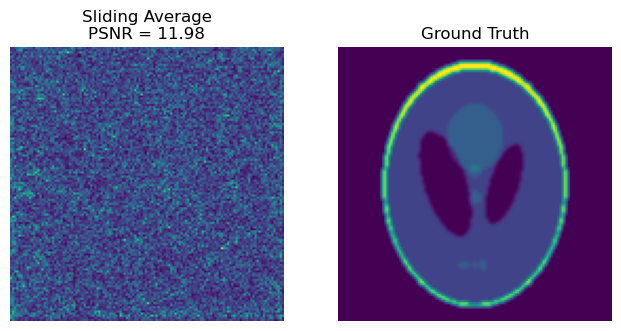

Iter:  100
SSIM:  0.6124482629059946
NMSE:  -13.440604209899902


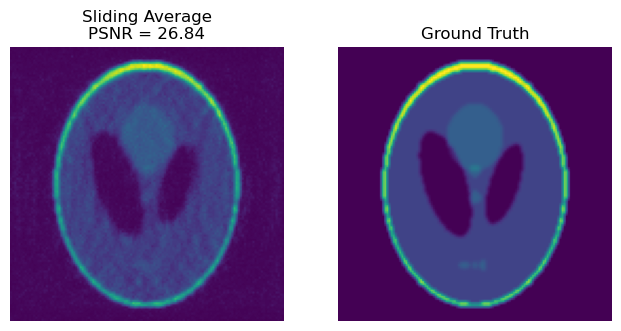

Iter:  200
SSIM:  0.7520487807888797
NMSE:  -17.890165328979492


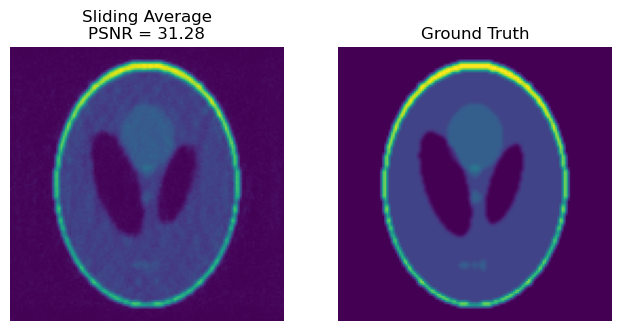

Iter:  300
SSIM:  0.8211813519372528
NMSE:  -20.392318725585938


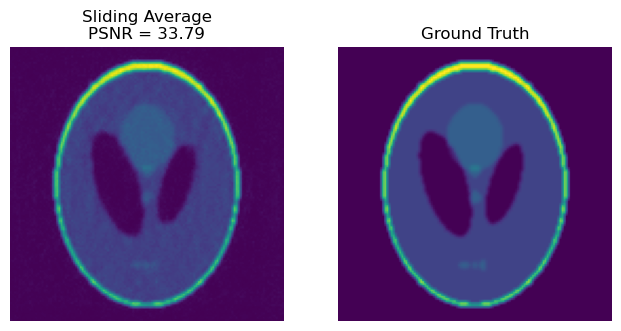

Iter:  400
SSIM:  0.8549755360857505
NMSE:  -21.75655746459961


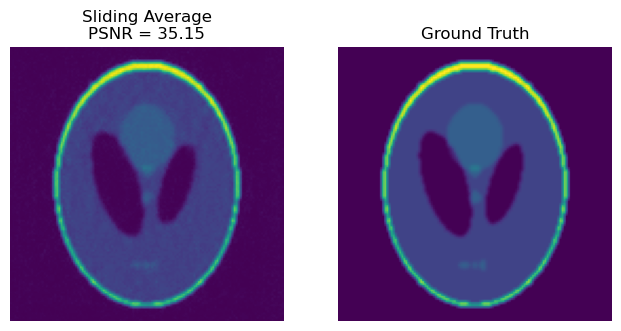

Iter:  500
SSIM:  0.8694254855521636
NMSE:  -22.477108001708984


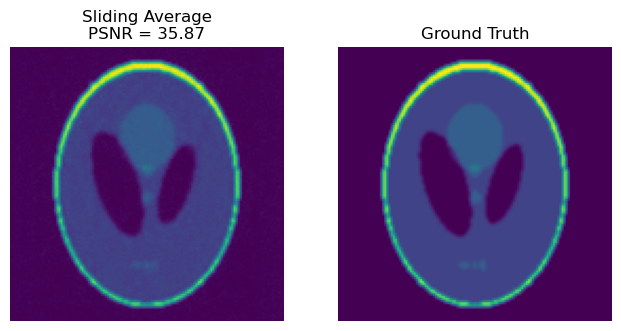

Iter:  600
SSIM:  0.8740655703820932
NMSE:  -22.918922424316406


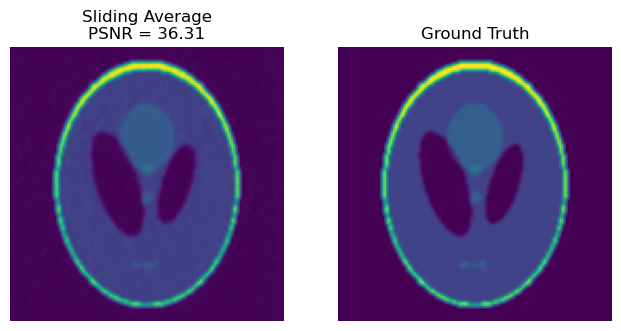

Iter:  700
SSIM:  0.8743618566205611
NMSE:  -23.143321990966797


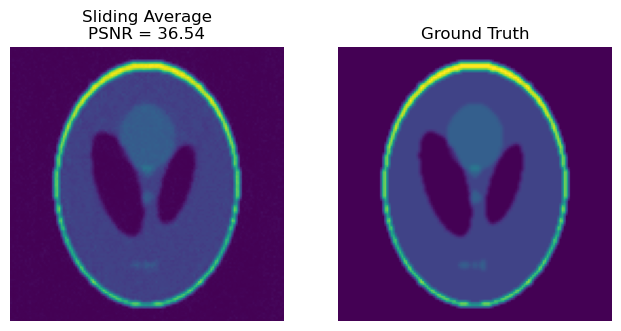

Iter:  800
SSIM:  0.8757415157505365
NMSE:  -23.2576904296875


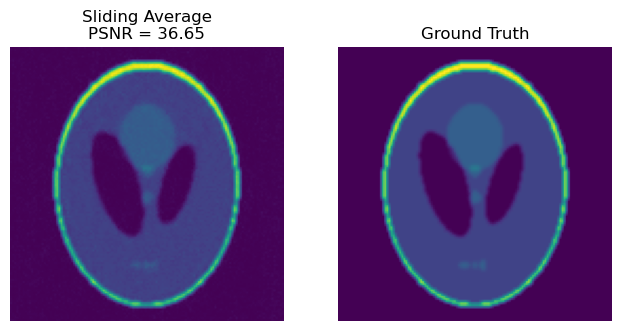

Iter:  900
SSIM:  0.8748427014662249
NMSE:  -23.41071128845215


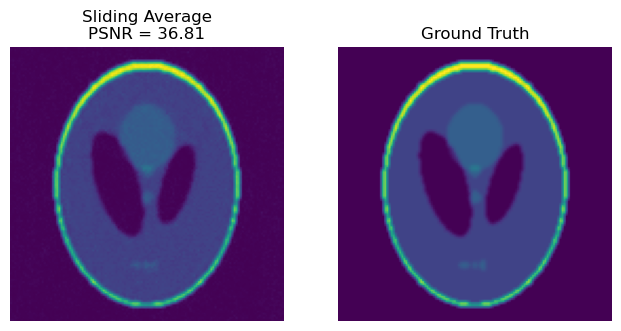

Iter:  1000
SSIM:  0.8738364530930782
NMSE:  -23.43975067138672


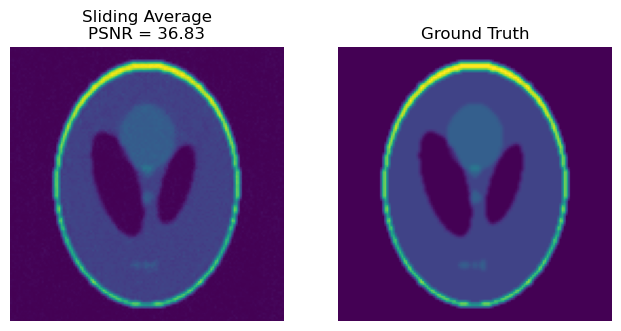

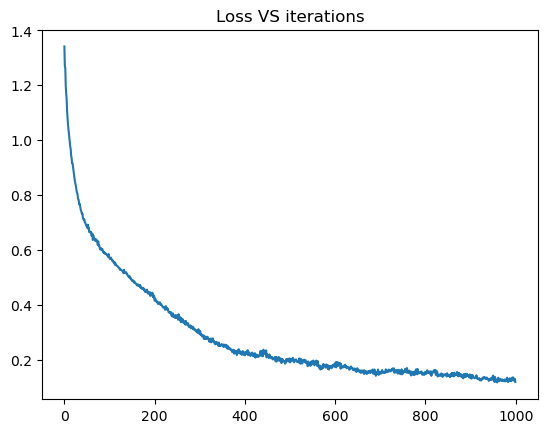

SSIM:  0.7006091902570357
NMSE:  -22.628620472693314


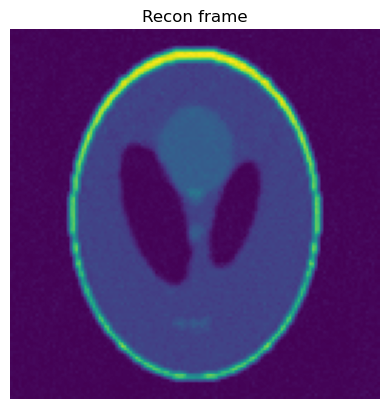


frame  2
Iter:  1
SSIM:  0.06533613872549403
NMSE:  2.0747642517089844


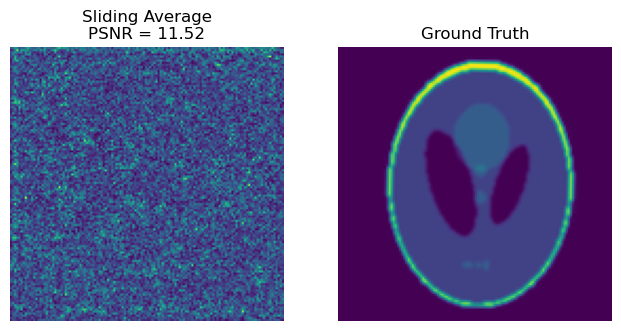

KeyboardInterrupt: 

In [8]:
xHat_SSDIP = np.zeros((2*N,n[0],n[1]))

for i in range(N): #N #2
    print("\nframe ", i+1)  
    ## noisy kspace
    ksp = torch.zeros(1,1,n[0],n[1], dtype=torch.complex64) # complex
    ksp_gt = torch.zeros(1,1,n[0],n[1], dtype=torch.complex64) # complex
    ksp[0,0,:,:] = np_to_torch(ynN[2*i,:,:]) + 1j*np_to_torch(ynN[2*i+1,:,:])
    ## ground truth kspace
    ksp_gt[0,0,:,:] = np_to_torch(yN[2*i,:,:]) + 1j*np_to_torch(yN[2*i+1,:,:])
    gt = ksp_and_mps_to_gt(ksp_gt)
    # print(gt.shape, gt.dtype)

    # 2nd optimizer for refernce: flexible w.r.t. LR
    ref = Variable(torch.rand((1,2,n[0],n[1])), requires_grad=True)
    optimizer2 = optim.Adam([ref], lr = 1e-1)

    net = ExtraDeepUNet(n_channels=2, n_classes=2)
    #net= nn.DataParallel(net).to(device)
    init_weights(net, init_type='normal',init_gain=0.02)
    optimizer = optim.Adam(net.parameters(), lr = learning_rate)


    # data normalization
    with torch.no_grad():
        scale_factor = torch.linalg.norm(net(ref))/torch.linalg.norm(gt)
        target_ksp = scale_factor * ksp

    gt = torch.abs(gt)/torch.max(torch.abs(gt))

    mask_from_file = np_to_torch(mskN[i,:,:])

    # CUDA:
    mask_from_file = mask_from_file
    # avg_ksp = avg_ksp.type(dtype)
    target_ksp = target_ksp
    # ref = ref.to(device)
    net = net
    
    ref = ref

    # training:
    losses = [] # track loss over iterations
    psnrs = []
    avg_psnrs = []
    exp_weight = .99
    k=3 # noise perturbations
    out_avg = torch.zeros_like(torch.abs(gt))

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        optimizer2.zero_grad()
        noise_max = torch.max(ref)/2
        random_smoothing_temp = torch.zeros_like(ref)
        for jj in range(k):
            noise = noise_max * torch.rand(*ref.shape) # uniform 
        
            net_output = net(ref + noise).squeeze()
            random_smoothing_temp += net_output
        net_output_final = random_smoothing_temp/3
        #print(net_output_final.shape)
        net_output_final = torch.view_as_complex(net_output_final.squeeze().permute(1,2,0).contiguous())
        
        pred_ksp = mps_and_gt_to_ksp( net_output_final)
        
        loss = torch.linalg.norm(mask_from_file * target_ksp - mask_from_file * pred_ksp.squeeze()) \
            + alpha * torch.linalg.norm(ref - net_output_final)
        
        
        loss.backward()
        optimizer.step()
        optimizer2.step()
        with torch.no_grad():
            out = torch.abs(ksp_and_mps_to_gt(pred_ksp)).squeeze()
            out /= torch.max(out)
            # print(out.size())
            psnr = compute_psnr(np.squeeze(torch_to_np(gt)), torch_to_np(torch.unsqueeze(out, dim=0)))
            psnrs.append(psnr)

            losses.append(loss.item())

            out_avg = out_avg * exp_weight + out * (1 - exp_weight)
            avg_psnr = compute_psnr(np.squeeze(torch_to_np(gt)), np.squeeze(torch_to_np(out_avg))/float(out_avg.max().item()))
            avg_psnrs.append(avg_psnr)
            
            # avg_ksp = avg_ksp * exp_weight + pred_ksp * (1 - exp_weight)
            if PLOT:
                if epoch ==0 or (epoch+1)%(show_every) == 0:
                    print("Iter: ", epoch+1)
                    print("SSIM: ", compute_ssim(np.squeeze(torch_to_np(gt)), np.squeeze(torch_to_np(out_avg))/float(out_avg.max().item())))
                    print("NMSE: ", compute_nmse(gt, out_avg/float(out_avg.max().item())).item())
                    plt.figure(figsize=(12,12))
                    plt.subplot(131)
                    plt.imshow(np.squeeze(torch_to_np(out_avg)))
                    plt.title('Sliding Average\nPSNR = ' + str(round(avg_psnr, 2)))
                    plt.axis('OFF')
                
                    plt.subplot(132)
                    plt.imshow(np.squeeze(np.abs(gt)))
                    plt.title('Ground Truth')
                    #plt.colorbar()
                    plt.axis('OFF')
                
                    plt.show()
    if PLOT:
            # plot loss over iterations:
        plt.figure()
        plt.plot(np.log10(losses))
        plt.title("Loss VS iterations")
        plt.show()
            # plt.


    ## hard data consistency:
    ksp_ac = mask_from_file * target_ksp 
    ksp_es = (1-mask_from_file) * pred_ksp
    ksp_cor = ksp_ac + ksp_es

    # ksp to image:
    img = ksp_and_mps_to_gt(ksp_cor)

    img_np = np.abs(np.squeeze(torch_to_np(img)))
    img_tor = torch.abs(torch.squeeze(img))

    # print("After Hard DC:")
    print("SSIM: ", compute_ssim(img_np/np.max(img_np), np.squeeze(torch_to_np(gt)), data_range =(img_np/np.max(img_np)).max() - (img_np/np.max(img_np)).min()))
    print("NMSE: ", compute_nmse(gt, img_tor/float(img_tor.max().item())).item())
    plt.imshow(np.abs(np.squeeze(torch_to_np(img))))
    plt.title("Recon frame")
    plt.axis("OFF")
    plt.show()

    ###

    xHat = np.squeeze(torch_to_np(img))
    xHat_SSDIP[2*i,:,:] = xHat.real
    xHat_SSDIP[2*i+1,:,:] = xHat.imag

if sv_SSDIP:
    np.save(data_load + 'xHat_SSDIP_N%d_R%f.npy'%(N,R), xHat_SSDIP)
    print("Recon images saved!")           